In [241]:
import numpy as np
import pandas as pd
from collections import Counter

%matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')

import seaborn as sns
sns.set_theme()
sns.set_context('paper')

Using matplotlib backend: MacOSX


In [189]:
qsos = pd.read_csv('qso_full_sample.csv', header=1)
qsos

,specobjid,plate,mjd,fiberID,subclass,z,oiii_5007_flux,oiii_5007_flux_err,h_alpha_flux,h_alpha_flux_err,h_beta_flux,h_beta_flux_err,nii_6584_flux,nii_6584_flux_err,w1,w2,w3
0,1005512498008320000,893,52589,305,STARBURST,0.038501,1086.95700,13.445690,5999.0170,42.020350,1582.36400,15.046550,3010.8450,20.696370,12.089,11.908,7.834
1,2165278474745440256,1923,53319,629,STARBURST,0.016457,375.86400,5.281759,2068.5040,13.648870,575.60020,5.900801,593.1110,5.842029,12.812,12.661,8.762
2,2908305081193490432,2583,54095,384,STARBURST,0.051987,6372.96200,38.295890,6812.0910,41.000700,2008.34700,13.510290,741.5893,5.987211,13.591,13.268,9.258
3,837747358904117248,744,52251,283,BROADLINE,0.022764,154.59780,10.752410,198.6793,14.250820,68.47856,9.791917,162.8001,12.672370,11.233,11.288,10.554
4,2837441290109478912,2520,54584,631,BROADLINE,0.034883,78.40385,3.972700,117.0103,4.839863,34.39631,3.565499,206.4456,5.043667,11.898,11.943,10.131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1533579628139014144,1362,53050,378,STARFORMING,0.025236,115.03360,4.033701,781.4837,7.725008,214.29840,4.172729,322.2542,5.217882,12.396,12.399,9.657
956,3247247139872466944,2884,54526,552,STARFORMING,0.056460,339.05710,9.086666,3180.3280,24.726840,521.87720,8.259108,1724.3280,17.019960,10.726,10.093,6.381
957,527064949625743360,468,51912,523,NaN,0.035238,397.04130,9.734199,339.9698,12.175190,53.31718,6.877068,579.7974,12.467780,11.857,11.851,10.645
958,3240437313582426112,2878,54465,354,AGN BROADLINE,0.044007,33.92199,3.269411,171.5769,3.730943,56.84223,3.040776,114.2342,4.025399,12.271,12.251,9.992


In [190]:
qsos.shape

(960, 17)

In [191]:
qsos.columns

Index(['specobjid', 'plate', 'mjd', 'fiberID', 'subclass', 'z',
       'oiii_5007_flux', 'oiii_5007_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'nii_6584_flux',
       'nii_6584_flux_err', 'w1', 'w2', 'w3'],
      dtype='object')

In [192]:
Counter(qsos['subclass'])

Counter({'STARBURST': 153,
         'BROADLINE': 317,
         nan: 94,
         'STARFORMING': 213,
         'STARFORMING BROADLINE': 29,
         'AGN BROADLINE': 69,
         'AGN': 84,
         'STARBURST BROADLINE': 1})

Here, I'll plot the distribution of the fluxes to get an idea of the data.

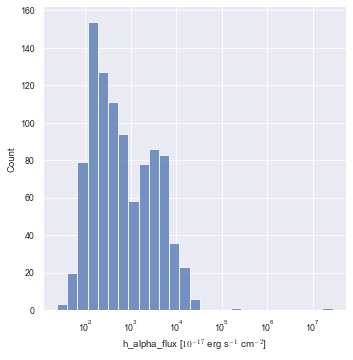

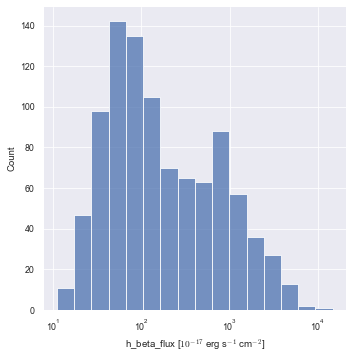

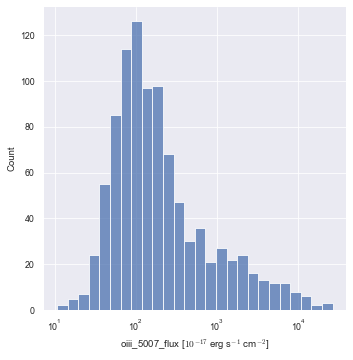

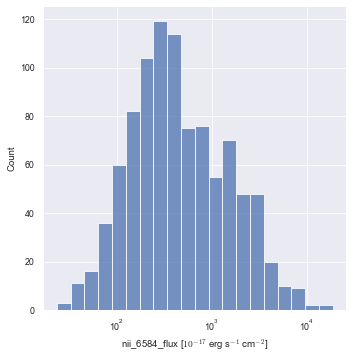

In [193]:
cols = ['h_alpha_flux', 'h_beta_flux', 'oiii_5007_flux', 'nii_6584_flux']

for col in cols:
    sns.displot(data=qsos, x=col, log_scale=True)

    plt.xlabel(col + r' [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$]')

    # plt.savefig('distr_' + col + '.pdf')

    plt.show()

# BPT Diagrams

In [194]:
qsos['nii_h_alpha'] = qsos.apply(lambda x: x['nii_6584_flux'] / x['h_alpha_flux'], axis=1)
qsos['nii_h_alpha_log'] = qsos.apply(lambda x: np.log10(x['nii_h_alpha']), axis=1)
qsos['oiii_h_beta'] = qsos.apply(lambda x: x['oiii_5007_flux'] / x['h_beta_flux'], axis=1)
qsos['oiii_h_beta_log'] = qsos.apply(lambda x: np.log10(x['oiii_h_beta']), axis=1)

### BPT with SDSS subclasses

In [342]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=qsos, x='nii_h_alpha', y='oiii_h_beta', palette='colorblind', 
                hue='subclass', style='subclass', size='subclass', sizes=(100, 20))

plt.xlabel(r'[NII] / H$\alpha$', fontsize=13)
plt.ylabel(r'[OIII] / H$\beta$', fontsize=13)

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='lower left', fontsize=10)

# plt.savefig('BPT_diagram_sdss_subclasses.pdf')

plt.show()

## BPT with Theoretical Lines

### Kauffman et al. 2003

In [201]:
def BPT_class_Kauff(oiii_h_beta, nii_h_alpha):
    # second condition is to avoid double lines
    if (np.log10(oiii_h_beta) < 0.61 / (np.log10(nii_h_alpha) - 0.05) + 1.3) and (np.log10(nii_h_alpha) < 0.0):
        return 'Star Forming'
    else:
        return 'AGN'

### Kewley et al. 2001

In [205]:
def BPT_class_Kew(oiii_h_beta, nii_h_alpha):
    if np.log10(oiii_h_beta) < 0.61 / (np.log10(nii_h_alpha) - 0.47) + 1.19:
        return 'Star Forming'
    else:
        return 'AGN'

### Schawinski et al. 2007

In [257]:
def BPT_class_Scha(oiii_h_beta, nii_h_alpha):
    if np.log10(oiii_h_beta) < 1.05 * np.log10(nii_h_alpha) + 0.45:
        return 'LINER'
    else:
        return 'Seyfert'

In [258]:
qsos['BPT Kauffman'] = qsos.apply(lambda x: BPT_class_Kauff(x['oiii_h_beta'], x['nii_h_alpha']), axis=1)
qsos['BPT Kewley'] = qsos.apply(lambda x: BPT_class_Kew(x['oiii_h_beta'], x['nii_h_alpha']), axis=1)
qsos['BPT Schawinski'] = qsos.apply(lambda x: BPT_class_Scha(x['oiii_h_beta'], x['nii_h_alpha']), axis=1)

In [284]:
def BPT_final_class(row):
    if row['BPT Kauffman'] != row['BPT Kewley']:
        return 'Composite'
    elif (row['BPT Kauffman'] == row['BPT Kewley']) and row['BPT Kauffman'] == 'AGN':
        return row['BPT Schawinski']
    else:
        return row['BPT Kauffman']

In [285]:
qsos['BPT final'] = qsos.apply(lambda x: BPT_final_class(x), axis=1)
Counter(qsos['BPT final'])

Counter({'Composite': 237, 'Star Forming': 234, 'LINER': 399, 'Seyfert': 90})

In [293]:
plt.figure(figsize=(12, 8))

plt.xlim(-3.6, 0.6)
plt.ylim(-1.1, 1.5)

sns.scatterplot(data=qsos, x='nii_h_alpha_log', y='oiii_h_beta_log', palette='colorblind', 
                hue='BPT final', style='BPT final', size='BPT final', sizes=(90, 40))

# ------------------------------------------------------------------------------------------------
# Kauffman
x_to_plot = np.linspace(qsos['nii_h_alpha_log'].min(), 0)
plt.plot(x_to_plot, 0.61 / (x_to_plot - 0.05) + 1.3, label='Kauffman et al. 2003', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='dashdot')

# ------------------------------------------------------------------------------------------------
# Kewley
x_to_plot_1 = np.linspace(qsos['nii_h_alpha_log'].min(), qsos['nii_h_alpha_log'].max())
plt.plot(x_to_plot_1, 0.61 / (x_to_plot_1 - 0.47) + 1.19, label='Kewley et al. 2001', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='dashed')

# ------------------------------------------------------------------------------------------------
# Schawinski
x_to_plot_2 = np.linspace(-0.1853, qsos['nii_h_alpha_log'].max())
plt.plot(x_to_plot_2, 1.05 * x_to_plot_2 + 0.45, label='Schawinski et al. 2007', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='solid')

# ------------------------------------------------------------------------------------------------

plt.xlabel(r'log [NII] / H$\alpha$', fontsize=13)
plt.ylabel(r'log [OIII] / H$\beta$', fontsize=13)

plt.legend(loc='lower left', fontsize=12)

# plt.savefig('BPT_with_lines.pdf')

plt.show()

# Mid-IR WISE Colours

In [318]:
def wise_color_color(w1, w2, w3):
    '''
    Returns the class according to Figure 11b in Jarret et al. 2017
    '''
    color_x = w2 - w3
    color_y = w1 - w2

    if color_y >= 0.8:
        return 'AGN & (u)LIRGs'
    elif color_y < 0.8 and color_x < 2.0:
        return 'Spheroids'
    elif color_y < 0.8 and color_x > 3.5:
        return 'SF Disks'
    else:
        return 'Inter. Disks'

In [319]:
qsos['wise class'] = qsos.apply(lambda x: wise_color_color(x['w1'], x['w2'], x['w3']), axis=1)
Counter(qsos['wise class'])

Counter({'SF Disks': 261,
         'Spheroids': 405,
         'Inter. Disks': 290,
         'AGN & (u)LIRGs': 4})

In [320]:
qsos['w1-w2'] = qsos.apply(lambda x: x['w1'] - x['w2'], axis=1)
qsos['w2-w3'] = qsos.apply(lambda x: x['w2'] - x['w3'], axis=1)

## One Random Object

In [321]:
random_obj = qsos.loc[qsos['w1-w2']>=0.8].sample(n=1, random_state=42)
random_obj

,specobjid,plate,mjd,fiberID,subclass,z,oiii_5007_flux,oiii_5007_flux_err,h_alpha_flux,h_alpha_flux_err,...,nii_h_alpha_log,oiii_h_beta,oiii_h_beta_log,BPT Kauffman,BPT Kewley,BPT Schawinski,BPT final,wise class,w1-w2,w2-w3
488,1999772022116214784,1776,53858,632,STARBURST,0.021559,4133.134,31.57422,16633.67,98.18549,...,-0.381678,1.100931,0.04176,AGN,Star Forming,LINER,Composite,AGN & (u)LIRGs,0.882,3.696


## Plotting Color-Color

In [301]:
# print(sns.color_palette('colorblind').as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [341]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.ylim(-0.4, 1.45)
plt.xlim(0, 5.1)

sns.scatterplot(data=qsos, x='w2-w3', y='w1-w2', palette='colorblind', 
                hue='wise class', style='wise class', size='wise class', sizes=(70, 20))

plt.scatter(random_obj['w2-w3'], random_obj['w1-w2'], c='darkviolet', 
            edgecolors='white', marker='*', s=230, label='Random Object')

plt.vlines([2.0, 3.5], -0.4, 0.8, 
           linestyles='dashdot', color='k', alpha=0.7, linewidth=1.7)
plt.hlines(0.8, -0.5, 5.5, linestyles='dashdot', color='k', alpha=0.7, linewidth=1.7)

props = dict(boxstyle='round', color='#cc78bc', alpha=0.95)
ax.text(0.8, 0.9, 'AGN & (u)LIRGs', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, color='white')

props_1 = dict(boxstyle='round', color='#029e73', alpha=0.8)
ax.text(0.45, 0.08, 'Intermediate Disks', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props_1, color='white')

props_2 = dict(boxstyle='round', color='#de8f05', alpha=0.8)
ax.text(0.15, 0.08, 'Spheroids', transform=ax.transAxes, fontsize=14,
       verticalalignment='top', bbox=props_2, color='white')

props_3 = dict(boxstyle='round', color='#0173b2', alpha=0.9)
ax.text(0.8, 0.08, 'SF Disks', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props_3, color='white')

plt.xlabel(r'W2 - W3 [mag]', fontsize=13)
plt.ylabel(r'W1 - W2 [mag]', fontsize=13)

plt.legend(loc='upper left', fontsize=11)

# plt.savefig('wise_color_color.pdf')

plt.show()

In [316]:
plt.figure(figsize=(12, 8))

plt.xlim(-3.6, 0.6)
plt.ylim(-1.1, 1.5)

sns.scatterplot(data=qsos, x='nii_h_alpha_log', y='oiii_h_beta_log', palette='colorblind', 
                hue='BPT final', style='BPT final', size='BPT final', sizes=(90, 40))

plt.scatter(random_obj['nii_h_alpha_log'], random_obj['oiii_h_beta_log'], 
            c='darkviolet', edgecolors='white', marker='*', s=260, label='Random Object')

# ------------------------------------------------------------------------------------------------
# Kauffman
x_to_plot = np.linspace(qsos['nii_h_alpha_log'].min(), 0)
plt.plot(x_to_plot, 0.61 / (x_to_plot - 0.05) + 1.3, label='Kauffman et al. 2003', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='dashdot')

# ------------------------------------------------------------------------------------------------
# Kewley
x_to_plot_1 = np.linspace(qsos['nii_h_alpha_log'].min(), qsos['nii_h_alpha_log'].max())
plt.plot(x_to_plot_1, 0.61 / (x_to_plot_1 - 0.47) + 1.19, label='Kewley et al. 2001', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='dashed')

# ------------------------------------------------------------------------------------------------
# Schawinski
x_to_plot_2 = np.linspace(-0.1853, qsos['nii_h_alpha_log'].max())
plt.plot(x_to_plot_2, 1.05 * x_to_plot_2 + 0.45, label='Schawinski et al. 2007', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='solid')

# ------------------------------------------------------------------------------------------------

plt.xlabel(r'log [NII] / H$\alpha$', fontsize=13)
plt.ylabel(r'log [OIII] / H$\beta$', fontsize=13)

plt.legend(loc='lower left', fontsize=12)

# plt.savefig('BPT_with_lines_and_random.pdf')

plt.show()